In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
import networkx as nx
import time

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid') 
sns.set_palette("muted") 

# Курсовая работа: Анализ рыночной корзины для выявления устойчивых наборов товаров

Данный Jupyter Notebook объединяет код для глав 2 и 3 курсовой работы.
- **Глава 2**: Подготовка данных 'Groceries dataset' и исследовательский анализ для MBA.
- **Глава 3**: Разработка, оценка и улучшение модели поиска ассоциативных правил.

## Глава 2. Подготовка данных и анализ

### 2.1. Описание используемого набора данных 'Groceries dataset'
Загрузка данных из файла `Groceries_dataset.csv` и первоначальный осмотр: размеры, типы данных, количество уникальных значений и первые строки.

In [2]:
try:
    df_raw = pd.read_csv('Groceries_dataset.csv')
    print("Набор данных 'Groceries_dataset.csv' успешно загружен.")
    print(f"Размеры исходного DataFrame: {df_raw.shape}")

    print("\nОбщая информация о DataFrame:")
    df_raw.info()

    print("\nТипы данных столбцов:")
    print(df_raw.dtypes)

    print("\nКоличество уникальных значений для каждого столбца:")
    print(df_raw.nunique())

    print("\nПервые 10 строк исходного DataFrame:")
    print(df_raw.head(10).to_markdown(index=False))
    
    df_processed = df_raw.copy()

except FileNotFoundError:
    print("ОШИБКА: Файл 'Groceries_dataset.csv' не найден. Пожалуйста, проверьте путь к файлу.")
    df_processed = pd.DataFrame() 
except Exception as e:
    print(f"Произошла ошибка при загрузке или первоначальном анализе данных: {e}")
    df_processed = pd.DataFrame()

Набор данных 'Groceries_dataset.csv' успешно загружен.
Размеры исходного DataFrame: (38765, 3)

Общая информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB

Типы данных столбцов:
Member_number       int64
Date               object
itemDescription    object
dtype: object

Количество уникальных значений для каждого столбца:
Member_number      3898
Date                728
itemDescription     167
dtype: int64

Первые 10 строк исходного DataFrame:
|   Member_number | Date       | itemDescription   |
|----------------:|:-----------|:------------------|
|            1808 | 21-07-2015 | tropical fruit    |
|            2552 | 05-01-2015 | whole 

### 2.2. Этапы предварительной обработки и очистки данных
Проверка на пропущенные значения, преобразование типов данных (`Date` в datetime, `Member_number` в строковый), стандартизация текстовых описаний товаров (`itemDescription`) и удаление дубликатов строк.

In [ ]:
if not df_processed.empty:
    print("Проверка на наличие пропущенных значений:")
    print(df_processed.isnull().sum())
    if df_processed.isnull().sum().sum() == 0:
        print("Пропущенные значения в исходных данных отсутствуют.")
    else:
        print("В данных присутствуют пропущенные значения. Обработка не включена в данный скрипт.")

    # Преобразование 'Date' в datetime, указываем формат явно, т.к. он DD-MM-YYYY
    df_processed['Date'] = pd.to_datetime(df_processed['Date'], format='%d-%m-%Y')
    df_processed['Member_number'] = df_processed['Member_number'].astype(str)
    print("\nТипы данных 'Date' и 'Member_number' после преобразования:")
    print(df_processed.dtypes[['Date', 'Member_number']])

    df_processed['itemDescription'] = df_processed['itemDescription'].str.lower().str.strip()
    print(f"\nКоличество уникальных товаров после очистки 'itemDescription': {df_processed['itemDescription'].nunique()}")

    num_duplicates_before = df_processed.duplicated().sum()
    if num_duplicates_before > 0:
        df_processed.drop_duplicates(inplace=True)
        print(f"\nУдалено {num_duplicates_before} полных дубликатов строк.")
        print(f"Новые размеры DataFrame: {df_processed.shape}")
    else:
        print("\nПолные дубликаты строк отсутствуют.")
        print(f"Текущие размеры DataFrame: {df_processed.shape}")
else:
    print("Предобработка пропущена, так как исходный DataFrame пуст.")

Проверка на наличие пропущенных значений:
Member_number      0
Date               0
itemDescription    0
dtype: int64
Пропущенные значения в исходных данных отсутствуют.

Типы данных 'Date' и 'Member_number' после преобразования:
Date             datetime64[ns]
Member_number            object
dtype: object

Количество уникальных товаров после очистки 'itemDescription': 167

Удалено 759 полных дубликатов строк.
Новые размеры DataFrame: (38006, 3)


### 2.3. Формирование транзакционной базы данных
Группировка товаров по уникальным покупкам (комбинация 'Member_number' и 'Date') для формирования списка транзакций. Затем эти транзакции кодируются в формат one-hot encoding с помощью `TransactionEncoder`.

In [4]:
if not df_processed.empty:
    transactions_list = df_processed.groupby(['Member_number', 'Date'])['itemDescription'].apply(list).tolist()
    print(f"Общее количество полученных транзакций: {len(transactions_list)}")
    print("\nПримеры первых 3-х транзакций:")
    for i in range(min(3, len(transactions_list))):
        print(f"Транзакция {i+1}: {transactions_list[i]}")

    te = TransactionEncoder()
    te_ary = te.fit(transactions_list).transform(transactions_list)
    df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

    print(f"\nРазмеры one-hot encoded DataFrame: {df_onehot.shape} (транзакций, уникальных товаров)")
    print("\nПервые 5 строк one-hot encoded DataFrame:")
    print(df_onehot.head().to_markdown())
else:
    print("Формирование транзакционной базы пропущено, DataFrame для обработки пуст.")
    transactions_list = [] 
    df_onehot = pd.DataFrame() 

Общее количество полученных транзакций: 14963

Примеры первых 3-х транзакций:
Транзакция 1: ['whole milk', 'pastry', 'salty snack']
Транзакция 2: ['sausage', 'whole milk', 'semi-finished bread', 'yogurt']
Транзакция 3: ['soda', 'pickled vegetables']

Размеры one-hot encoded DataFrame: (14963, 167) (транзакций, уникальных товаров)

Первые 5 строк one-hot encoded DataFrame:
|    |   abrasive cleaner |   artif. sweetener |   baby cosmetics |   bags |   baking powder |   bathroom cleaner |   beef |   berries |   beverages |   bottled beer |   bottled water |   brandy |   brown bread |   butter |   butter milk |   cake bar |   candles |   candy |   canned beer |   canned fish |   canned fruit |   canned vegetables |   cat food |   cereals |   chewing gum |   chicken |   chocolate |   chocolate marshmallow |   citrus fruit |   cleaner |   cling film/bags |   cocoa drinks |   coffee |   condensed milk |   cooking chocolate |   cookware |   cream |   cream cheese |   curd |   curd cheese |   d

### 2.4. Описательный анализ подготовленных транзакционных данных
Исследование характеристик транзакционной базы: частота товаров, длина транзакций, временная динамика покупательской активности и со-встречаемость популярных товаров.

#### 2.4.1. Анализ частоты встречаемости товаров (Рис. 2.1, Рис. 2.2)
Визуализация топ-15 самых популярных и топ-15 наименее популярных товаров.

Всего уникальных товаров для анализа частоты: 167


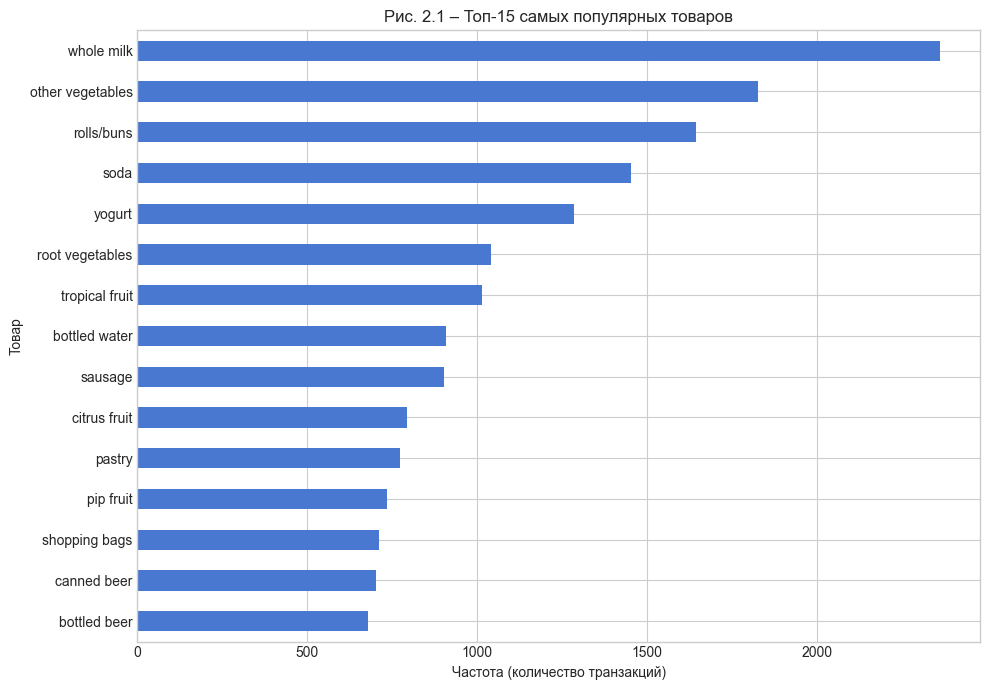


Топ-3 самых популярных товара (для сверки с текстом курсовой):
- whole milk: 2363 транзакций
- other vegetables: 1827 транзакций
- rolls/buns: 1646 транзакций


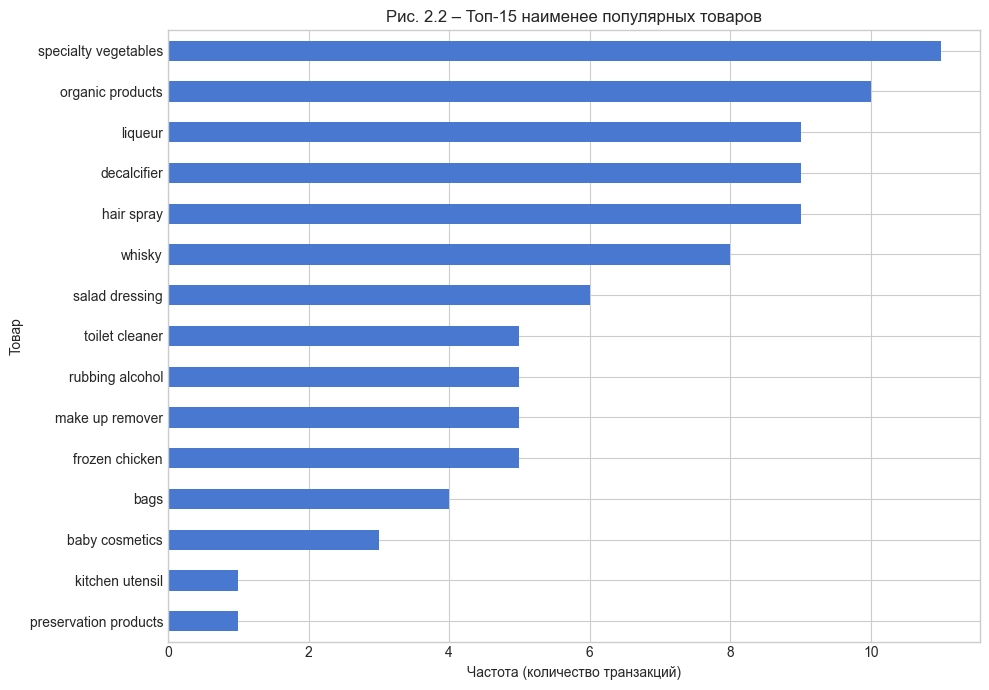


Топ-3 наименее популярных товара (для сверки с текстом курсовой):
- preservation products: 1 транзакций
- kitchen utensil: 1 транзакций
- baby cosmetics: 3 транзакций


In [5]:
if not df_onehot.empty:
    item_frequencies = df_onehot.sum().sort_values(ascending=False)
    print(f"Всего уникальных товаров для анализа частоты: {len(item_frequencies)}")
    
    N_TOP = 15
    plt.figure(figsize=(10, 7))
    item_frequencies.head(N_TOP).plot(kind='barh')
    plt.title(f'Рис. 2.1 – Топ-{N_TOP} самых популярных товаров')
    plt.xlabel('Частота (количество транзакций)')
    plt.ylabel('Товар')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("\nТоп-3 самых популярных товара (для сверки с текстом курсовой):")
    for i in range(min(3, len(item_frequencies))):
        print(f"- {item_frequencies.index[i]}: {item_frequencies.iloc[i]} транзакций")

    N_BOTTOM = 15
    plt.figure(figsize=(10, 7))
    # Берем хвост, затем сортируем по возрастанию для корректного отображения barh
    item_frequencies.tail(N_BOTTOM).sort_values(ascending=True).plot(kind='barh')
    plt.title(f'Рис. 2.2 – Топ-{N_BOTTOM} наименее популярных товаров')
    plt.xlabel('Частота (количество транзакций)')
    plt.ylabel('Товар')
    plt.tight_layout()
    plt.show()
    
    print(f"\nТоп-3 наименее популярных товара (для сверки с текстом курсовой):")
    least_popular_disp = item_frequencies.tail(min(3, len(item_frequencies))).sort_values(ascending=True)
    for item, freq in least_popular_disp.items():
        print(f"- {item}: {freq} транзакций")
else:
    print("Анализ частоты товаров пропущен, one-hot DataFrame пуст.")
    item_frequencies = pd.Series()

#### 2.4.2. Анализ длин транзакций (Рис. 2.3)
Распределение количества товаров в одной транзакции (корзине) и его описательные статистики.

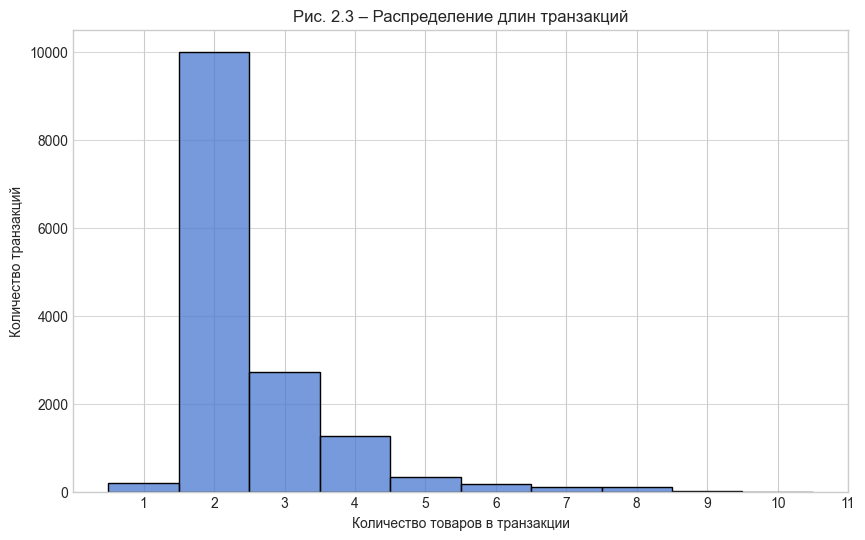


Описательные статистики для длин транзакций:
|       |           0 |
|:------|------------:|
| count | 14963       |
| mean  |     2.54    |
| std   |     1.06099 |
| min   |     1       |
| 25%   |     2       |
| 50%   |     2       |
| 75%   |     3       |
| max   |    10       |


In [6]:
if transactions_list: 
    transaction_lengths = [len(t) for t in transactions_list]
    
    if transaction_lengths: 
        max_len_val = max(transaction_lengths) if transaction_lengths else 1

        plt.figure(figsize=(10, 6))
        sns.histplot(transaction_lengths, bins=range(1, max_len_val + 2), kde=False, discrete=True)
        plt.title('Рис. 2.3 – Распределение длин транзакций')
        plt.xlabel('Количество товаров в транзакции')
        plt.ylabel('Количество транзакций')
        step = max(1, (max_len_val + 1) // 15)
        plt.xticks(np.arange(1, max_len_val + 2, step)) 
        plt.grid(axis='y', alpha=0.75)
        plt.show()
        
        transaction_lengths_series = pd.Series(transaction_lengths)
        print("\nОписательные статистики для длин транзакций:")
        print(transaction_lengths_series.describe().to_markdown())
    else:
        print("Список длин транзакций пуст, анализ невозможен.")
else:
    print("Анализ длин транзакций пропущен, список транзакций пуст.")

#### 2.4.3. Анализ временной динамики покупательской активности (Рис. 2.4, Рис. 2.5)
Динамика общего количества проданных товарных позиций по месяцам и распределение количества транзакций по дням недели.

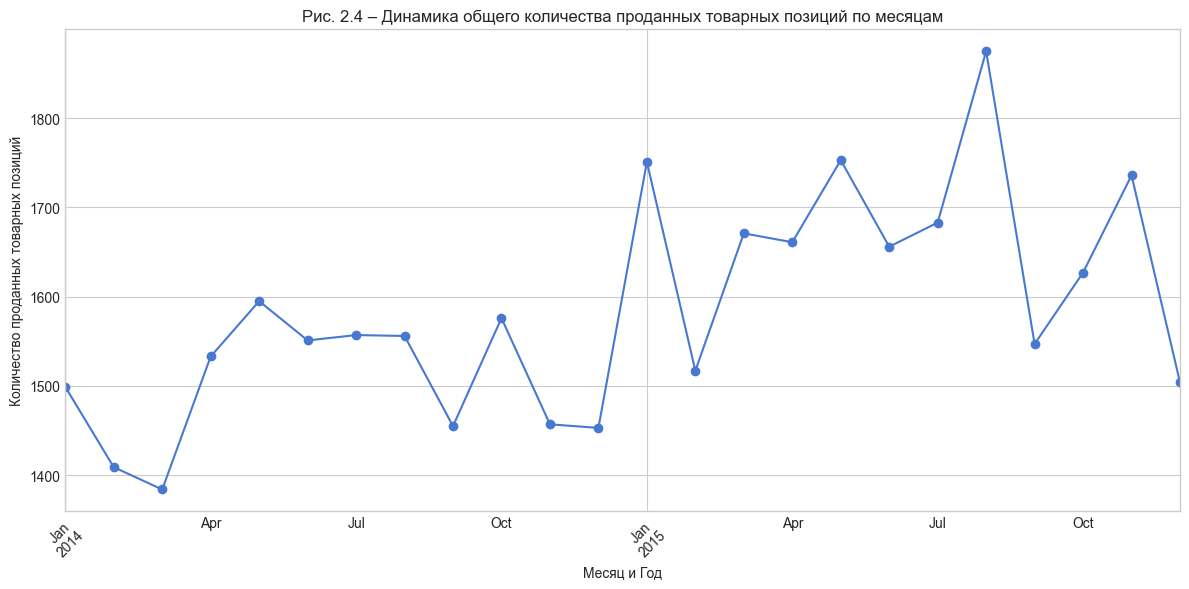


Наблюдения по продажам товарных позиций (для сверки с текстом курсовой):
- Пик: 2015-08 (1875 поз.).
- Мин: 2014-03 (1384 поз.).


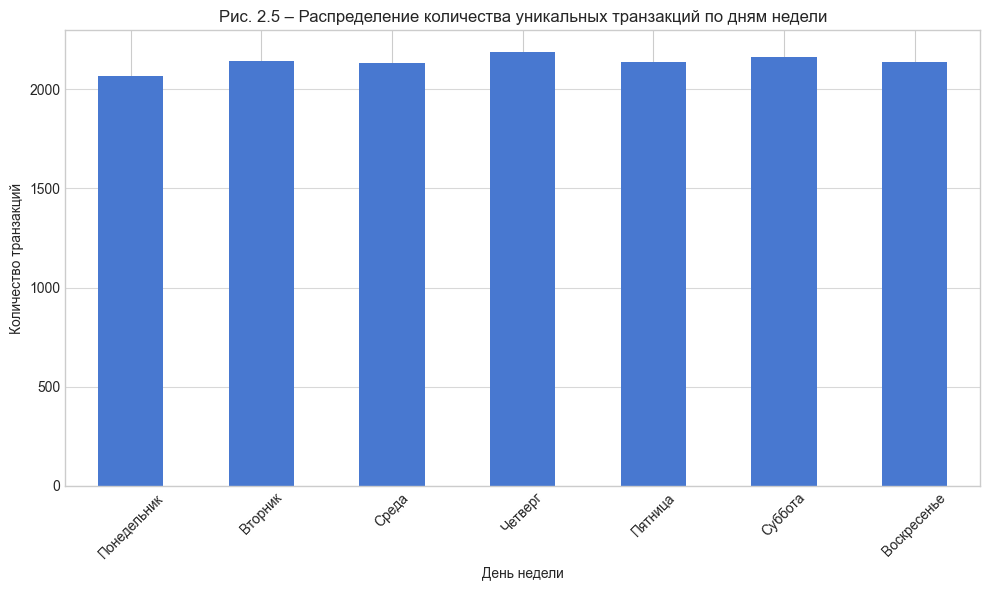


Распределение транзакций по дням недели (для сверки с текстом курсовой):
| DayOfWeek   |   Количество транзакций |
|:------------|------------------------:|
| Понедельник |                    2067 |
| Вторник     |                    2142 |
| Среда       |                    2131 |
| Четверг     |                    2188 |
| Пятница     |                    2136 |
| Суббота     |                    2161 |
| Воскресенье |                    2138 |


In [7]:
if not df_processed.empty:
    df_processed['YearMonth'] = df_processed['Date'].dt.to_period('M')
    monthly_item_sales = df_processed.groupby('YearMonth').size()

    if not monthly_item_sales.empty:
        plt.figure(figsize=(12, 6))
        monthly_item_sales.plot(kind='line', marker='o')
        plt.title('Рис. 2.4 – Динамика общего количества проданных товарных позиций по месяцам')
        plt.xlabel('Месяц и Год')
        plt.ylabel('Количество проданных товарных позиций')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        print("\nНаблюдения по продажам товарных позиций (для сверки с текстом курсовой):")
        print(f"- Пик: {monthly_item_sales.idxmax()} ({monthly_item_sales.max()} поз.).")
        print(f"- Мин: {monthly_item_sales.idxmin()} ({monthly_item_sales.min()} поз.).")
    else:
        print("Нет данных для анализа продаж по месяцам.")

    # Группируем по Date и Member_number чтобы посчитать уникальные транзакции (чеки)
    transactions_by_date_member = df_processed.groupby(['Date', 'Member_number']).size().reset_index(name='TransactionCount') 
    # Используем pd.to_datetime, так как 'Date' в transactions_by_date_member может быть просто объектом после reset_index
    transactions_by_date_member['DayOfWeek'] = pd.to_datetime(transactions_by_date_member['Date']).dt.day_name()
    # Задаем порядок дней недели для корректной сортировки на графике
    day_order_en = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    day_order_ru = ["Понедельник", "Вторник", "Среда", "Четверг", "Пятница", "Суббота", "Воскресенье"]
    day_map_en_ru = dict(zip(day_order_en, day_order_ru))

    # Считаем количество уникальных транзакций (чеков) по дням недели
    transactions_by_dayofweek_en = transactions_by_date_member['DayOfWeek'].value_counts().reindex(day_order_en)
    transactions_by_dayofweek_ru = transactions_by_dayofweek_en.rename(index=day_map_en_ru)

    if not transactions_by_dayofweek_ru.empty:
        plt.figure(figsize=(10, 6))
        transactions_by_dayofweek_ru.plot(kind='bar')
        plt.title('Рис. 2.5 – Распределение количества уникальных транзакций по дням недели')
        plt.xlabel('День недели')
        plt.ylabel('Количество транзакций')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.75)
        plt.tight_layout()
        plt.show()
        
        print("\nРаспределение транзакций по дням недели (для сверки с текстом курсовой):")
        df_for_markdown = transactions_by_dayofweek_ru.to_frame(name="Количество транзакций")
        print(df_for_markdown.to_markdown())
    else:
        print("Нет данных для анализа транзакций по дням недели.")
else:
    print("Временной анализ пропущен, DataFrame для обработки пуст.")

#### 2.4.4. Матрица со-встречаемости для топ-N товаров (Рис. 2.6)
Визуализация частоты совместных покупок для 15 самых популярных товаров с помощью тепловой карты.

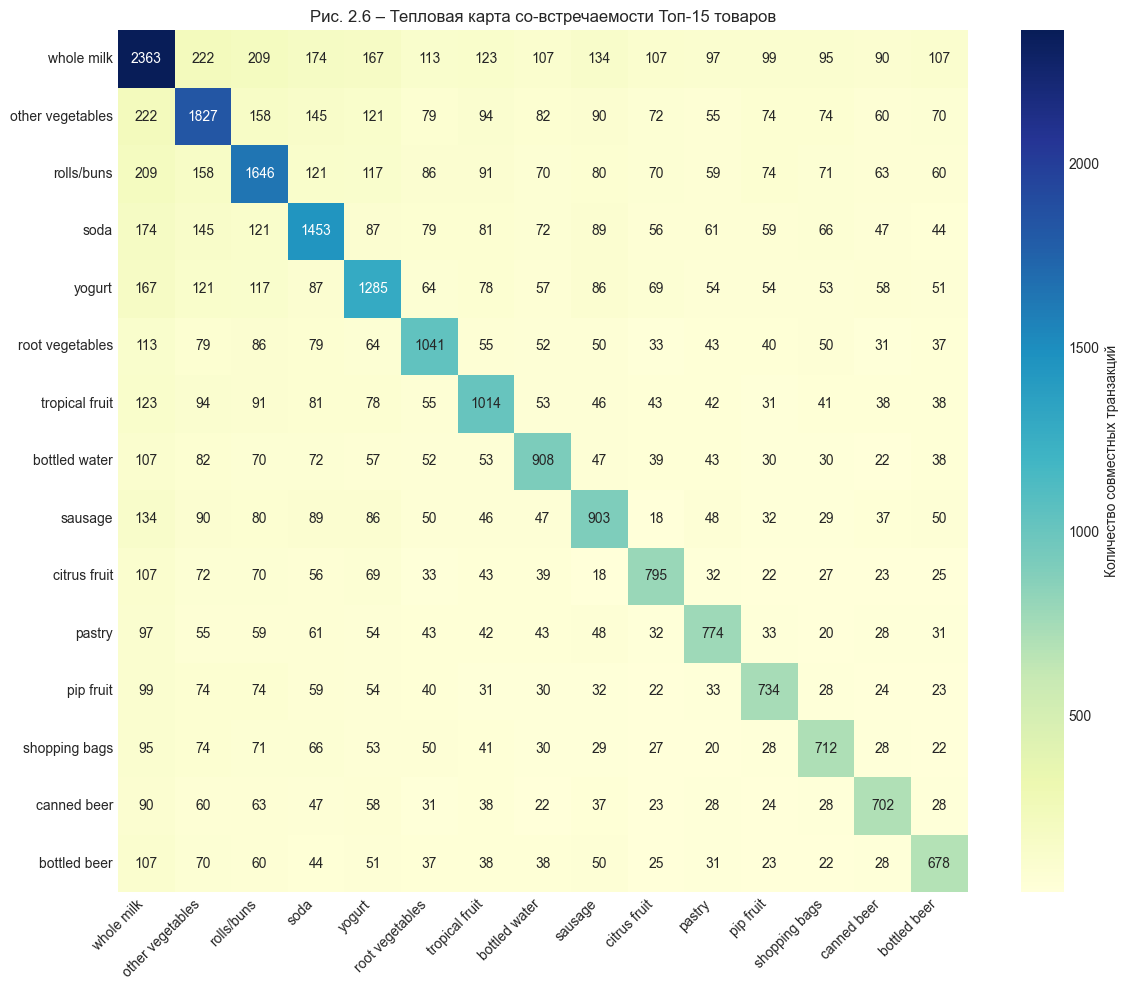


Топ-3 пар (из топ-товаров) с наибольшей со-встречаемостью (для сверки с текстом курсовой):
- Пара: whole milk и other vegetables, Со-встречаемость: 222 транзакций.
- Пара: whole milk и rolls/buns, Со-встречаемость: 209 транзакций.
- Пара: whole milk и soda, Со-встречаемость: 174 транзакций.


In [8]:
if not df_onehot.empty and 'item_frequencies' in locals() and not item_frequencies.empty:
    N_HEATMAP_ITEMS = 15
    actual_n_heatmap_items = min(N_HEATMAP_ITEMS, len(item_frequencies))
    
    if actual_n_heatmap_items > 1:
        top_n_items_for_heatmap = item_frequencies.head(actual_n_heatmap_items).index.tolist()
        df_onehot_top_n = df_onehot[top_n_items_for_heatmap]

        cooccurrence_matrix = pd.DataFrame(index=top_n_items_for_heatmap, columns=top_n_items_for_heatmap, dtype=float)
        for item1 in top_n_items_for_heatmap:
            for item2 in top_n_items_for_heatmap:
                if item1 == item2: 
                    cooccurrence_matrix.loc[item1, item2] = df_onehot_top_n[item1].sum()
                else: 
                    cooccurrence_matrix.loc[item1, item2] = (df_onehot_top_n[item1] & df_onehot_top_n[item2]).sum()
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cooccurrence_matrix.astype(int), annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Количество совместных транзакций'})
        plt.title(f'Рис. 2.6 – Тепловая карта со-встречаемости Топ-{actual_n_heatmap_items} товаров')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        pairs_cooccurrence = []
        for i in range(actual_n_heatmap_items):
            for j in range(i + 1, actual_n_heatmap_items):
                pairs_cooccurrence.append(
                    ((top_n_items_for_heatmap[i], top_n_items_for_heatmap[j]), 
                     cooccurrence_matrix.iloc[i, j])
                )
        
        sorted_pairs_cooccurrence = sorted(pairs_cooccurrence, key=lambda x: x[1], reverse=True)
        print("\nТоп-3 пар (из топ-товаров) с наибольшей со-встречаемостью (для сверки с текстом курсовой):")
        for pair_info in sorted_pairs_cooccurrence[:min(3, len(sorted_pairs_cooccurrence))]:
            print(f"- Пара: {pair_info[0][0]} и {pair_info[0][1]}, Со-встречаемость: {int(pair_info[1])} транзакций.")
    else:
        print("Недостаточно товаров для построения матрицы со-встречаемости (требуется >1).")
elif df_onehot.empty:
    print("Анализ со-встречаемости пропущен, one-hot DataFrame пуст.")
else: 
    print("Анализ со-встречаемости пропущен, item_frequencies не определены (возможно, CELL 5 не был выполнен или не дал результатов).")

## Глава 3. Разработка, оценка и улучшение модели поиска ассоциативных правил

На этом этапе применяются алгоритмы Apriori и FP-Growth для поиска ассоциативных правил. Осуществляется выбор параметров, оценка и фильтрация правил. Данные, подготовленные в Главе 2 (`df_onehot`, `df_processed`, `transactions_list`), используются для моделирования.

### 3.1. Выбор и обоснование программных инструментов и библиотек
Используемые библиотеки: Pandas, Mlxtend, Matplotlib, Seaborn, NetworkX, Time. Их выбор обусловлен распространенностью, функциональностью и эффективностью для задач анализа данных и MBA.

### 3.2. Особенности оценки моделей MBA: Подготовка данных для оценки стабильности
Для оценки стабильности правил полный набор транзакций `df_onehot` разделяется на две случайные непересекающиеся подвыборки (70% и 30%).

In [9]:
if not df_onehot.empty:
    sample1_frac = 0.7
    df_onehot_sample1 = df_onehot.sample(frac=sample1_frac, random_state=42)
    df_onehot_sample2 = df_onehot.drop(df_onehot_sample1.index)
    print(f"Размеры подвыборок для проверки стабильности (для сверки с текстом курсовой):")
    print(f"- df_onehot_sample1 (70%): {df_onehot_sample1.shape[0]} транзакций")
    print(f"- df_onehot_sample2 (30%): {df_onehot_sample2.shape[0]} транзакций")
else:
    print("Разделение данных на подвыборки пропущено, df_onehot пуст.")
    df_onehot_sample1 = pd.DataFrame()
    df_onehot_sample2 = pd.DataFrame()

Размеры подвыборок для проверки стабильности (для сверки с текстом курсовой):
- df_onehot_sample1 (70%): 10474 транзакций
- df_onehot_sample2 (30%): 4489 транзакций


### 3.3. Применение алгоритмов Apriori и FP-Growth для поиска ассоциативных правил

#### 3.3.1. Поиск частых наборов товаров: Эксперименты и выбор алгоритма/`min_support` (Таблица 3.1)
Эксперименты с `min_support` для Apriori и FP-Growth, сравнение производительности и выбор оптимального алгоритма и `min_support`.

In [10]:
frequent_itemsets_final = pd.DataFrame() 
FINAL_MIN_SUPPORT = None                 
PREFERRED_ALGORITHM_NAME = "N/A"         
PREFERRED_ALGORITHM_FUNC = apriori
df_results_fi = pd.DataFrame()

if not df_onehot.empty:
    min_support_values = [0.02, 0.01, 0.005, 0.003, 0.001] 
    print(f"Тестируемые значения `min_support`: {min_support_values}")

    results_frequent_itemsets = []
    for min_s in min_support_values:
        start_time_ap = time.time()
        fi_ap = apriori(df_onehot, min_support=min_s, use_colnames=True)
        t_ap = time.time() - start_time_ap
        results_frequent_itemsets.append({'Алгоритм': 'Apriori', 'min_support': min_s, 'Время (с)': t_ap, 'Кол-во частых наборов': len(fi_ap)})
        
        start_time_fp = time.time()
        fi_fp = fpgrowth(df_onehot, min_support=min_s, use_colnames=True)
        t_fp = time.time() - start_time_fp
        results_frequent_itemsets.append({'Алгоритм': 'FP-Growth', 'min_support': min_s, 'Время (с)': t_fp, 'Кол-во частых наборов': len(fi_fp)})
    
    df_results_fi = pd.DataFrame(results_frequent_itemsets)
    print("\nТаблица 3.1 (воспроизведенная) – Сравнение производительности Apriori и FP-Growth:")
    print(df_results_fi.to_markdown(index=False))

    time_ap_total = df_results_fi[df_results_fi['Алгоритм'] == 'Apriori']['Время (с)'].sum()
    time_fp_total = df_results_fi[df_results_fi['Алгоритм'] == 'FP-Growth']['Время (с)'].sum()

    if time_ap_total <= time_fp_total:
        PREFERRED_ALGORITHM_NAME = "Apriori"
        PREFERRED_ALGORITHM_FUNC = apriori
    else:
        PREFERRED_ALGORITHM_NAME = "FP-Growth"
        PREFERRED_ALGORITHM_FUNC = fpgrowth
    print(f"\nНа основе общего времени выполнения (Apriori: {time_ap_total:.5f}s, FP-Growth: {time_fp_total:.5f}s), {PREFERRED_ALGORITHM_NAME} выбран как предпочтительный.")
    
    PAPER_FINAL_MIN_SUPPORT = 0.001 
    frequent_itemsets_check = PREFERRED_ALGORITHM_FUNC(df_onehot, min_support=PAPER_FINAL_MIN_SUPPORT, use_colnames=True)
    
    if len(frequent_itemsets_check) > 0 :
        FINAL_MIN_SUPPORT = PAPER_FINAL_MIN_SUPPORT
        frequent_itemsets_final = frequent_itemsets_check
        print(f"В соответствии с курсовой, выбран `min_support` = {FINAL_MIN_SUPPORT} ({PREFERRED_ALGORITHM_NAME}). Найдено {len(frequent_itemsets_final)} частых наборов.")
    else:
        print(f"ПРЕДУПРЕЖДЕНИЕ: Выбор min_support={PAPER_FINAL_MIN_SUPPORT} из курсовой не дал частых наборов с использованием {PREFERRED_ALGORITHM_NAME}. Попытка автоподбора...")

        sorted_min_support_values_desc = sorted(min_support_values, reverse=True) 
        for current_min_s_try in sorted_min_support_values_desc: 
            temp_fi = PREFERRED_ALGORITHM_FUNC(df_onehot, min_support=current_min_s_try, use_colnames=True)
            if len(temp_fi) > 0: 
                FINAL_MIN_SUPPORT = current_min_s_try
                frequent_itemsets_final = temp_fi
                print(f"Автоматически выбран `min_support` = {FINAL_MIN_SUPPORT} ({PREFERRED_ALGORITHM_NAME}). Найдено {len(frequent_itemsets_final)} частых наборов.")
                break
        if FINAL_MIN_SUPPORT is None:
            FINAL_MIN_SUPPORT = min_support_values[-1]
            frequent_itemsets_final = PREFERRED_ALGORITHM_FUNC(df_onehot, min_support=FINAL_MIN_SUPPORT, use_colnames=True)
            print(f"ПРЕДУПРЕЖДЕНИЕ: Не удалось найти подходящий `min_support` с результатами. Используется самый низкий из протестированных: {FINAL_MIN_SUPPORT}. Найдено {len(frequent_itemsets_final)} частых наборов.")

else:
    print("Поиск частых наборов пропущен, df_onehot пуст.")

Тестируемые значения `min_support`: [0.02, 0.01, 0.005, 0.003, 0.001]

Таблица 3.1 (воспроизведенная) – Сравнение производительности Apriori и FP-Growth:
| Алгоритм   |   min_support |   Время (с) |   Кол-во частых наборов |
|:-----------|--------------:|------------:|------------------------:|
| Apriori    |         0.02  |   0.0469811 |                      38 |
| FP-Growth  |         0.02  |   0.068002  |                      38 |
| Apriori    |         0.01  |   0.116138  |                      69 |
| FP-Growth  |         0.01  |   0.207886  |                      69 |
| Apriori    |         0.005 |   0.223412  |                     126 |
| FP-Growth  |         0.005 |   0.665399  |                     126 |
| Apriori    |         0.003 |   0.372413  |                     216 |
| FP-Growth  |         0.003 |   1.70889   |                     216 |
| Apriori    |         0.001 |   1.44661   |                     750 |
| FP-Growth  |         0.001 |   9.48217   |                     

#### 3.3.2. Генерация ассоциативных правил и первичная фильтрация (Рис. 3.1)
Генерация правил-кандидатов из частых наборов, фильтрация по `lift > 1.0` и визуализация распределения метрик.

Сгенерировано 1200 потенциальных правил-кандидатов (min_conf=0.01).
После фильтрации по lift > 1.0 осталось 231 правил-кандидатов.

Рис. 3.1 – Распределение метрик для правил-кандидатов (Lift > 1.0):


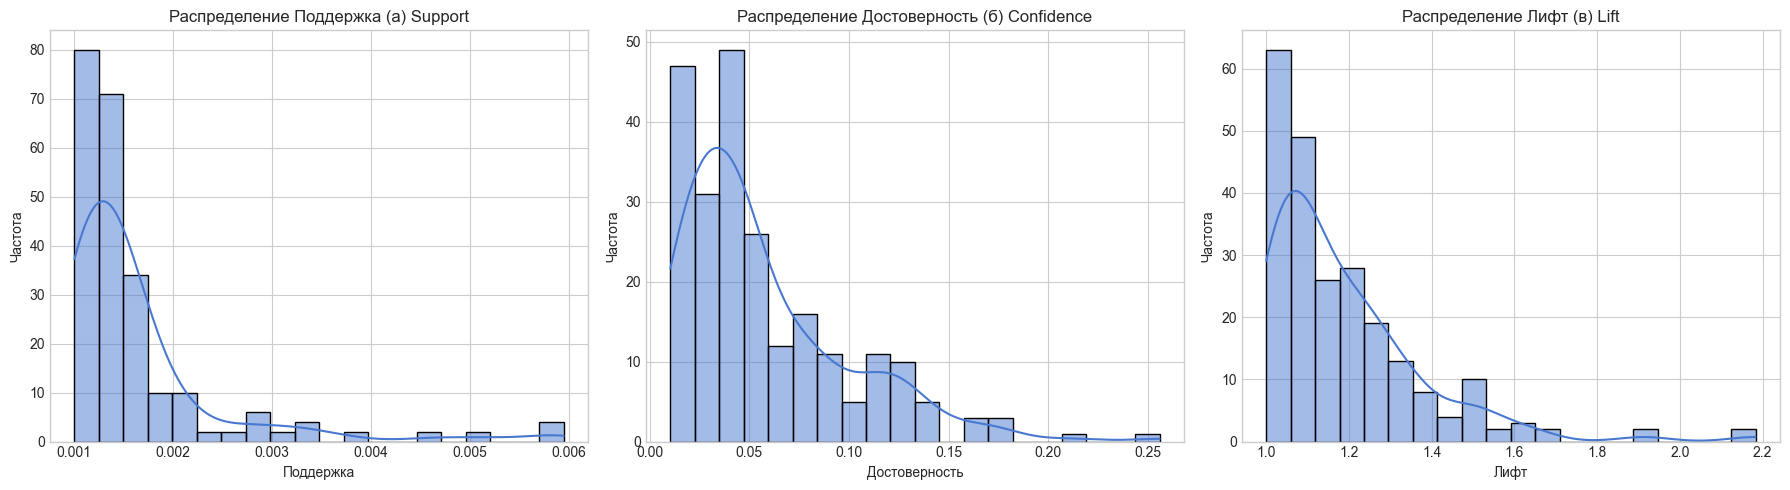

In [11]:
all_potential_rules = pd.DataFrame()
rules_meaningful_lift = pd.DataFrame()

FINAL_MIN_CONFIDENCE = 0.01
FINAL_MIN_LIFT = 1.000001    

if not frequent_itemsets_final.empty:
    INITIAL_LOW_CONFIDENCE = 0.01
    all_potential_rules = association_rules(frequent_itemsets_final, metric="confidence", min_threshold=INITIAL_LOW_CONFIDENCE)
    print(f"Сгенерировано {len(all_potential_rules)} потенциальных правил-кандидатов (min_conf={INITIAL_LOW_CONFIDENCE}).")

    if not all_potential_rules.empty:
        rules_meaningful_lift = all_potential_rules[all_potential_rules['lift'] > 1.0].copy()
        print(f"После фильтрации по lift > 1.0 осталось {len(rules_meaningful_lift)} правил-кандидатов.")

        if not rules_meaningful_lift.empty:
            print("\nРис. 3.1 – Распределение метрик для правил-кандидатов (Lift > 1.0):")
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            metrics_to_plot_fig3_1 = ['support', 'confidence', 'lift']
            subplot_titles_fig3_1 = ['(а) Support', '(б) Confidence', '(в) Lift']
            axis_labels_ru = ['Поддержка', 'Достоверность', 'Лифт']
            for i, metric in enumerate(metrics_to_plot_fig3_1):
                sns.histplot(rules_meaningful_lift[metric], ax=axes[i], kde=True, bins=20)
                axes[i].set_title(f'Распределение {axis_labels_ru[i]} {subplot_titles_fig3_1[i]}')
                axes[i].set_xlabel(axis_labels_ru[i]); axes[i].set_ylabel('Частота')
            plt.tight_layout() 
            plt.show()
        else:
            print("Нет правил-кандидатов с Lift > 1.0 для визуализации.")
    else:
        print("Не удалось сгенерировать правила-кандидаты.")
else:
    print("Генерация правил пропущена, набор частых элементов пуст.")

### 3.4. Оценка, фильтрация и отбор значимых ассоциативных правил (Таблица 3.2, Таблица 3.3)
Адаптивный подбор `min_confidence` и `min_lift` для получения ~10 правил. Вывод статистик и топ-N правил.

In [12]:
final_rules_filtered = pd.DataFrame()
final_rules_sorted = pd.DataFrame()

PAPER_FINAL_MIN_CONFIDENCE = 0.100
PAPER_FINAL_MIN_LIFT = 1.300

FINAL_MIN_CONFIDENCE = PAPER_FINAL_MIN_CONFIDENCE
FINAL_MIN_LIFT = PAPER_FINAL_MIN_LIFT

if not rules_meaningful_lift.empty:
    target_min_rules, target_max_rules = 10, 30
    
    final_rules_filtered = rules_meaningful_lift[
        (rules_meaningful_lift['confidence'] >= PAPER_FINAL_MIN_CONFIDENCE) &
        (rules_meaningful_lift['lift'] >= PAPER_FINAL_MIN_LIFT)
    ]
    print(f"Применены финальные пороги из курсовой: min_confidence={PAPER_FINAL_MIN_CONFIDENCE:.3f}, min_lift={PAPER_FINAL_MIN_LIFT:.3f}.")
    print(f"Получено {len(final_rules_filtered)} правил. (Ожидалось 10)")

    if not (target_min_rules <= len(final_rules_filtered) <= target_max_rules) or final_rules_filtered.empty :
        print("Результат отличается от ожидаемых ~10-30 правил или пуст. Запуск адаптивного подбора...")
        conf_thr_adaptive = sorted([0.3, 0.25, 0.2, 0.15, 0.1, 0.08, 0.05, 0.03, 0.01], reverse=True) 
        lift_thr_adaptive = sorted([2.0, 1.8, 1.5, 1.4, 1.3, 1.2, 1.1, 1.05, 1.01], reverse=True) # Ensure >1

        best_cand_rules_adaptive, best_cand_conf_adaptive, best_cand_lift_adaptive = pd.DataFrame(), None, None
        found_satisfactory_adaptive = False
        
        final_rules_filtered_temp = pd.DataFrame()

        for cur_conf_a in conf_thr_adaptive:
            if found_satisfactory_adaptive: break
            for cur_lift_a in lift_thr_adaptive:
                actual_lift_a = max(cur_lift_a, 1.000001)
                temp_rules_a = rules_meaningful_lift[
                    (rules_meaningful_lift['confidence'] >= cur_conf_a) &
                    (rules_meaningful_lift['lift'] >= actual_lift_a)
                ]
                num_temp_a = len(temp_rules_a)
                
                if target_min_rules <= num_temp_a <= target_max_rules:
                    FINAL_MIN_CONFIDENCE, FINAL_MIN_LIFT = cur_conf_a, actual_lift_a
                    final_rules_filtered_temp = temp_rules_a.copy()
                    found_satisfactory_adaptive = True
                    print(f"Адаптивно найден набор: {num_temp_a} правил (conf={FINAL_MIN_CONFIDENCE:.3f}, lift={FINAL_MIN_LIFT:.3f}).")
                    break
                elif num_temp_a > 0:
                    if best_cand_rules_adaptive.empty or \
                       (num_temp_a < target_max_rules * 2 and abs(num_temp_a - (target_min_rules+target_max_rules)/2) < abs(len(best_cand_rules_adaptive) - (target_min_rules+target_max_rules)/2)) or \
                       (len(best_cand_rules_adaptive) > target_max_rules*2 and num_temp_a < len(best_cand_rules_adaptive)):
                        best_cand_rules_adaptive, best_cand_conf_adaptive, best_cand_lift_adaptive = temp_rules_a.copy(), cur_conf_a, actual_lift_a
        
        if found_satisfactory_adaptive:
            final_rules_filtered = final_rules_filtered_temp # Assign from temp
        elif not best_cand_rules_adaptive.empty:
            final_rules_filtered, FINAL_MIN_CONFIDENCE, FINAL_MIN_LIFT = best_cand_rules_adaptive, best_cand_conf_adaptive, best_cand_lift_adaptive
            print(f"Адаптивный подбор: Цель [{target_min_rules}-{target_max_rules}] не достигнута. Лучший из найденных: {len(final_rules_filtered)} правил (conf={FINAL_MIN_CONFIDENCE:.3f}, lift={FINAL_MIN_LIFT:.3f}).")
        elif final_rules_filtered.empty and not rules_meaningful_lift.empty :
            FINAL_MIN_CONFIDENCE, FINAL_MIN_LIFT = conf_thr_adaptive[-1], max(lift_thr_adaptive[-1], 1.000001)
            final_rules_filtered = rules_meaningful_lift[
                (rules_meaningful_lift['confidence'] >= FINAL_MIN_CONFIDENCE) &
                (rules_meaningful_lift['lift'] >= FINAL_MIN_LIFT)
            ]
            if not final_rules_filtered.empty: 
                print(f"Адаптивный подбор (крайний случай): Использованы самые мягкие пороги: {len(final_rules_filtered)} правил (conf={FINAL_MIN_CONFIDENCE:.3f}, lift={FINAL_MIN_LIFT:.3f}).")
            else:
                print(f"Адаптивный подбор (крайний случай): Даже с самыми мягкими порогами (conf={FINAL_MIN_CONFIDENCE:.3f}, lift={FINAL_MIN_LIFT:.3f}) не найдено правил.")
    
    if not final_rules_filtered.empty:
        print(f"\nИспользуемые финальные пороги: `min_confidence`={FINAL_MIN_CONFIDENCE:.3f}, `min_lift`={FINAL_MIN_LIFT:.3f}. Итого: {len(final_rules_filtered)} правил.")
        metrics_to_describe = ['support', 'confidence', 'lift', 'leverage', 'conviction']
        print("\nТаблица 3.2 (воспроизведенная) – Описательные статистики метрик для финального набора правил:")
        print(final_rules_filtered[[m for m in metrics_to_describe if m in final_rules_filtered.columns]].describe().to_markdown())

        final_rules_sorted = final_rules_filtered.sort_values(by=['lift', 'confidence'], ascending=[False, False])
        print(f"\nТаблица 3.3 (воспроизведенная) – Финальный набор из {len(final_rules_sorted)} правил (сортировка: Lift, Confidence):")
        
        fr_disp = final_rules_sorted.copy()
        fr_disp['antecedents'] = fr_disp['antecedents'].apply(lambda x: ', '.join(list(x)))
        fr_disp['consequents'] = fr_disp['consequents'].apply(lambda x: ', '.join(list(x)))

        cols_table_3_3 = ['antecedents', 'consequents', 'support', 'confidence', 'lift', 'leverage', 'conviction']
        # Переименование столбцов для таблицы на русский
        cols_table_3_3_ru_map = {
            'antecedents': 'Антецеденты (Если)', 
            'consequents': 'Консеквенты (То)', 
            'support': 'Поддержка', 
            'confidence': 'Достоверность', 
            'lift': 'Лифт', 
            'leverage': 'Leverage', 
            'conviction': 'Conviction'
        }
        fr_disp_ru = fr_disp[[c for c in cols_table_3_3 if c in fr_disp.columns]].rename(columns=cols_table_3_3_ru_map)
        print(fr_disp_ru.head(min(15, len(fr_disp_ru))).to_markdown(index=False))
    else:
        print("ПРЕДУПРЕЖДЕНИЕ: Финальный набор правил пуст после фильтрации.")
else:
    print("Оценка и фильтрация правил пропущены (rules_meaningful_lift пуст).")

Применены финальные пороги из курсовой: min_confidence=0.100, min_lift=1.300.
Получено 10 правил. (Ожидалось 10)

Используемые финальные пороги: `min_confidence`=0.100, `min_lift`=1.300. Итого: 10 правил.

Таблица 3.2 (воспроизведенная) – Описательные статистики метрик для финального набора правил:
|       |      support |   confidence |      lift |     leverage |   conviction |
|:------|-------------:|-------------:|----------:|-------------:|-------------:|
| count | 10           |   10         | 10        | 10           |   10         |
| mean  |  0.00128985  |    0.149118  |  1.57838  |  0.000458404 |    1.06293   |
| std   |  0.000186517 |    0.0490144 |  0.275742 |  0.000170583 |    0.0312276 |
| min   |  0.0010693   |    0.105263  |  1.31573  |  0.000291798 |    1.03485   |
| 25%   |  0.00108601  |    0.118508  |  1.37995  |  0.000355259 |    1.04135   |
| 50%   |  0.00133663  |    0.129202  |  1.49399  |  0.000389222 |    1.04684   |
| 75%   |  0.00147029  |    0.159319  |  1.6

#### 3.4.1. Визуализация финального набора правил: Scatter Plot (Рис. 3.2)
График Support vs Confidence, где размер точки соответствует Support, а цвет - Lift.

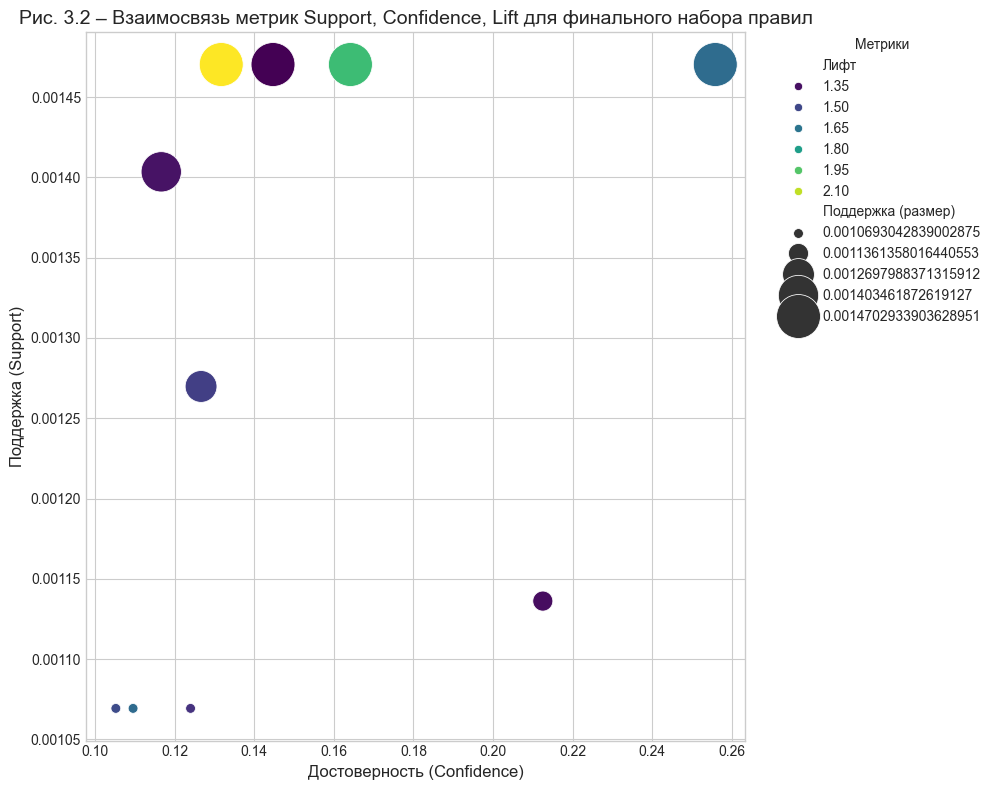

In [13]:
if not final_rules_filtered.empty and len(final_rules_filtered) > 1:
    plt.figure(figsize=(12, 8))
    scatter_plot = sns.scatterplot(
        x='confidence', 
        y='support', 
        size='support', # Размер точки по Support
        hue='lift',     # Цвет точки по Lift
        data=final_rules_filtered, 
        sizes=(50, 1000), # Минимальный и максимальный размер точек
        palette='viridis', # Цветовая схема для Lift
        legend='auto' 
    )
    plt.title('Рис. 3.2 – Взаимосвязь метрик Support, Confidence, Lift для финального набора правил', fontsize=14)
    plt.xlabel('Достоверность (Confidence)', fontsize=12)
    plt.ylabel('Поддержка (Support)', fontsize=12)
    plt.grid(True)
    
    # Настройка легенды
    handles, labels = scatter_plot.get_legend_handles_labels()
    new_labels = []
    for label in labels:
        if label.lower() == 'lift': new_labels.append('Лифт')
        elif label.lower() == 'support': new_labels.append('Поддержка (размер)')
        else: new_labels.append(label)
    
    if scatter_plot.legend_ is not None:
        plt.legend(handles, new_labels, title='Метрики', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()
elif not final_rules_filtered.empty and len(final_rules_filtered) == 1:
    print("Scatter plot пропущен: найдено только 1 правило. Отображение одной точки неинформативно.")
else:
    print("Scatter plot пропущен: финальный набор правил пуст или содержит менее 2 правил.")

#### 3.4.2. Визуализация финального набора правил: Сетевой граф (Рис. 3.3)
Сетевой граф для топ-N (например, 10, как в курсовой) наиболее сильных правил. Ребра показывают направление правила, их цвет - Lift, толщина - Confidence.

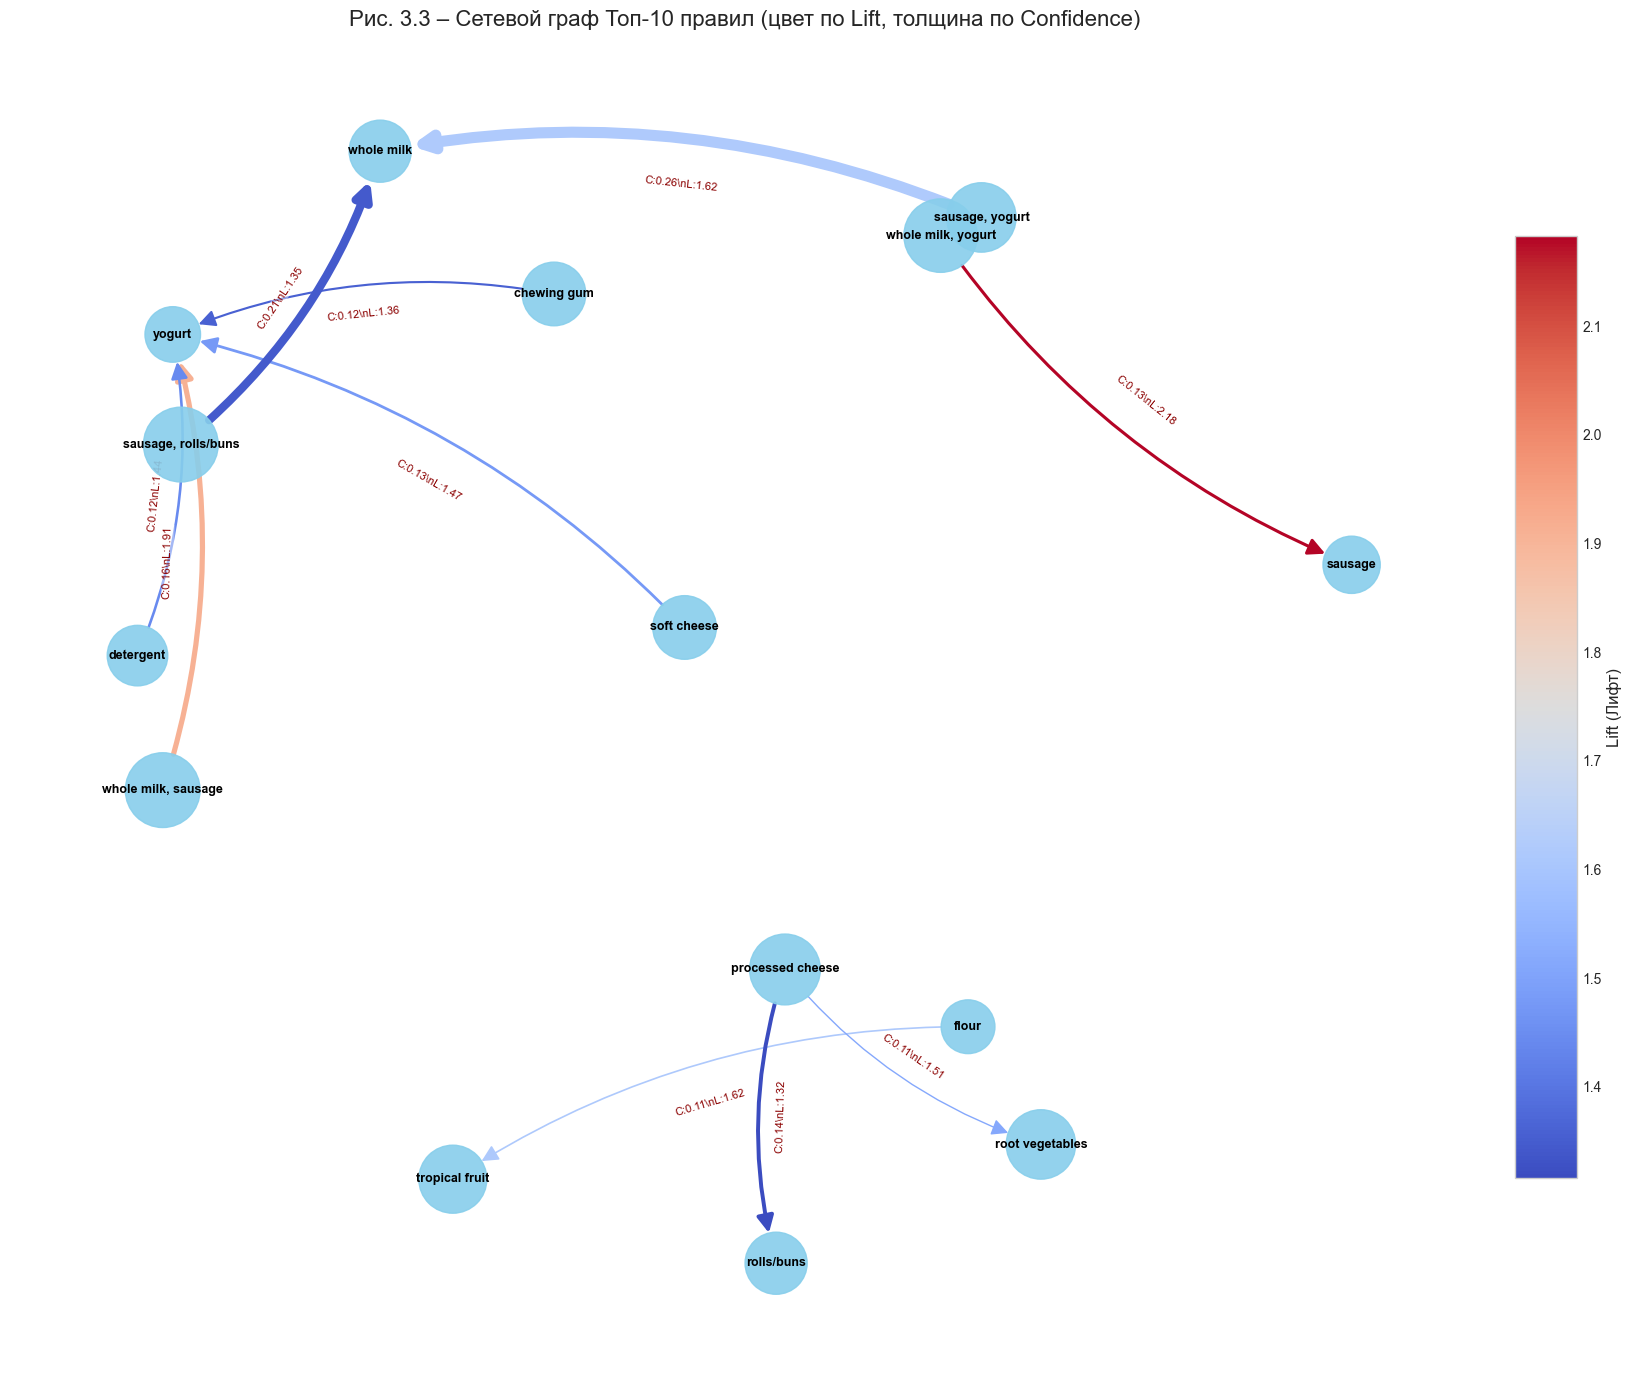

In [14]:
if not final_rules_sorted.empty:

    num_rules_for_graph = min(10, len(final_rules_sorted))
    rules_for_graph = final_rules_sorted.head(num_rules_for_graph) 
    
    if not rules_for_graph.empty:
        G = nx.DiGraph()
        for _, rule_item in rules_for_graph.iterrows(): 
            ant_str = ", ".join(list(rule_item['antecedents']))
            con_str = ", ".join(list(rule_item['consequents']))
            
            if not G.has_node(ant_str): G.add_node(ant_str, label=ant_str)
            if not G.has_node(con_str): G.add_node(con_str, label=con_str)
            
            G.add_edge(ant_str, con_str, 
                       lift=rule_item['lift'], 
                       confidence=rule_item['confidence'],
                       support=rule_item['support'])

        fig, ax = plt.subplots(figsize=(18, 14))
        
        pos = nx.spring_layout(G, k=1.5, iterations=80, seed=42, scale=2.0) # k и iterations для распределения, scale для общего масштаба
        
        node_sizes_dynamic = [len(str(node_label)) * 100 + 1000 for node_label in G.nodes()] 

        edge_lifts = [G[u][v]['lift'] for u,v in G.edges()] if G.edges() else []
        edge_confidences = [G[u][v]['confidence'] for u,v in G.edges()] if G.edges() else []
        
        min_conf, max_conf = (min(edge_confidences), max(edge_confidences)) if edge_confidences else (0,1)
        conf_range = (max_conf - min_conf) if (max_conf - min_conf) > 1e-6 else 1.0 
        edge_widths_dynamic = [1 + 7 * (conf - min_conf) / conf_range for conf in edge_confidences] if edge_confidences else []

        nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_sizes_dynamic, node_color='skyblue', alpha=0.9)
        nx.draw_networkx_labels(G, pos, ax=ax, font_size=9, font_weight='bold') 
        
        edges_drawn = nx.draw_networkx_edges(G, pos, ax=ax, arrowstyle='-|>', arrowsize=25, 
                                             edge_cmap=plt.cm.coolwarm, 
                                             edge_color=edge_lifts if edge_lifts else None, 
                                             width=edge_widths_dynamic,
                                             node_size=node_sizes_dynamic, 
                                             connectionstyle='arc3,rad=0.15') 

        edge_labels_graph = {(u,v): f"C:{d['confidence']:.2f}\\nL:{d['lift']:.2f}" for u,v,d in G.edges(data=True)}
        nx.draw_networkx_edge_labels(G,pos, ax=ax, edge_labels=edge_labels_graph,font_size=8, font_color='darkred',
                                     bbox=dict(facecolor='white', alpha=0.4, edgecolor='none', boxstyle='round,pad=0.1'))

        ax.set_title(f'Рис. 3.3 – Сетевой граф Топ-{len(rules_for_graph)} правил (цвет по Lift, толщина по Confidence)', size=16)
        ax.axis('off')

        if G.edges() and edge_lifts:
            vmin_lift = min(edge_lifts) if edge_lifts else 0
            vmax_lift = max(edge_lifts) if edge_lifts else 1
            if abs(vmin_lift - vmax_lift) < 1e-6 : vmax_lift = vmin_lift + 0.1 
            
            sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, 
                                      norm=plt.Normalize(vmin=vmin_lift, vmax=vmax_lift))
            sm.set_array(edge_lifts) 
            cbar = fig.colorbar(sm, ax=ax, shrink=0.7, aspect=15, pad=0.02) 
            cbar.set_label('Lift (Лифт)', fontsize=12)
        
        plt.tight_layout()
        plt.show()
    else: 
        print("Нет правил для построения сетевого графа (после отбора для графа).")
else: 
    print("Сетевой граф пропущен (final_rules_sorted пуст).")

#### 3.4.3. Анализ стабильности правил
Сравнение правил с полной выборки и подвыборки (70%) по тем же порогам.

In [ ]:
if not df_onehot_sample1.empty and not final_rules_sorted.empty and \
   FINAL_MIN_SUPPORT is not None and FINAL_MIN_CONFIDENCE is not None and FINAL_MIN_LIFT is not None:
    
    print("Анализ стабильности правил: Поиск правил на подвыборке 1 (70%)...")
    fi_s1 = PREFERRED_ALGORITHM_FUNC(df_onehot_sample1, min_support=FINAL_MIN_SUPPORT, use_colnames=True)
    rules_s1_filt = pd.DataFrame()

    if not fi_s1.empty:
        rules_s1_all_candidates = association_rules(fi_s1, metric="confidence", min_threshold=0.01)
        if not rules_s1_all_candidates.empty: 
            rules_s1_filt = rules_s1_all_candidates[
                (rules_s1_all_candidates['lift'] >= FINAL_MIN_LIFT) & 
                (rules_s1_all_candidates['confidence'] >= FINAL_MIN_CONFIDENCE) 
            ].copy()
        print(f"- На подвыборке 1 найдено: {len(rules_s1_filt)} правил (при supp>={FINAL_MIN_SUPPORT:.4f}, conf>={FINAL_MIN_CONFIDENCE:.3f}, lift>={FINAL_MIN_LIFT:.3f}).")
    else: 
        print(f"- На подвыборке 1 не найдено частых наборов (при min_supp={FINAL_MIN_SUPPORT:.4f}).")

    if not final_rules_sorted.empty and not rules_s1_filt.empty:
        def get_rule_id(rule_series): 
            return (tuple(sorted(list(rule_series['antecedents']))), tuple(sorted(list(rule_series['consequents']))))
            
        frs_copy_stability = final_rules_sorted.copy()
        rs1_copy_stability = rules_s1_filt.copy()
        
        frs_copy_stability['id'] = frs_copy_stability.apply(get_rule_id, axis=1)
        rs1_copy_stability['id'] = rs1_copy_stability.apply(get_rule_id, axis=1)
        
        common_rules = pd.merge(frs_copy_stability, rs1_copy_stability, on='id', suffixes=('_full', '_s1'))
        print(f"\nОбщих правил (полный набор vs подвыборка 1): {len(common_rules)}.")
        
        if not common_rules.empty and len(common_rules) > 1:
            print("  Корреляции метрик для общих правил:")
            metrics_for_corr_ru = {'lift': 'Лифт', 'confidence': 'Достоверность', 'support': 'Поддержка'}
            for metric_corr_en, metric_corr_ru_name in metrics_for_corr_ru.items():
                col_full, col_s1 = f'{metric_corr_en}_full', f'{metric_corr_en}_s1'
                if col_full in common_rules.columns and col_s1 in common_rules.columns:
                    if common_rules[col_full].nunique() > 1 and common_rules[col_s1].nunique() > 1:
                        correlation_value = common_rules[col_full].corr(common_rules[col_s1])
                        print(f"    Корр. {metric_corr_ru_name}: {correlation_value:.3f}" if pd.notnull(correlation_value) else f"    Корр. {metric_corr_ru_name}: N/A (нет вариации)")
                    else:
                        print(f"    Корр. {metric_corr_ru_name}: N/A (недостаточно вариации в данных для расчета)")
                else:
                     print(f"    Столбцы для метрики {metric_corr_en} не найдены в объединенном DataFrame.")
        elif not common_rules.empty : 
            print("  Найдено только 1 общее правило, корреляция не рассчитывается.")
        else: 
            print("  Нет общих правил для сравнения метрик.")
    elif final_rules_sorted.empty:
        print("  Пропуск сравнения метрик: нет правил из полного набора.")
    elif rules_s1_filt.empty:
        print("  Пропуск сравнения метрик: нет правил из подвыборки.")
else:
    print("Анализ стабильности пропущен (одно из условий не выполнено: df_onehot_sample1 пуст, final_rules_sorted пуст, или пороги FINAL_MIN_SUPPORT/CONFIDENCE/LIFT не определены).")

Анализ стабильности правил: Поиск правил на подвыборке 1 (70%)...
- На подвыборке 1 найдено: 11 правил (при supp>=0.0010, conf>=0.100, lift>=1.300).

Общих правил (полный набор vs подвыборка 1): 8.
  Корреляции метрик для общих правил:
    Корр. Лифт: 0.891
    Корр. Достоверность: 0.946
    Корр. Поддержка: 0.749


### 3.5. Выбор оптимального набора параметров и алгоритма
Итоговые значения `min_support`, `min_confidence`, `min_lift` и выбранный алгоритм.

In [16]:
print("--- Итоги выбора параметров и алгоритма (для сверки с текстом курсовой) ---")
if 'df_results_fi' in locals() and not df_results_fi.empty: 
    print(f"\nСводная таблица по производительности (Таблица 3.1):")
    df_results_fi_ru = df_results_fi.rename(columns={
        'Алгоритм': 'Алгоритм',
        'min_support': 'min_support',
        'Время (с)': 'Время (с)',
        'Кол-во частых наборов': 'Кол-во частых наборов'
    })
    print(df_results_fi_ru.to_markdown(index=False))
else: 
    print("Данные о сравнении производительности алгоритмов (Таблица 3.1) отсутствуют (возможно, CELL 10 не был выполнен).")

print(f"\nВыбранный алгоритм: {PREFERRED_ALGORITHM_NAME if 'PREFERRED_ALGORITHM_NAME' in locals() and PREFERRED_ALGORITHM_NAME != 'N/A' else 'Не определен (CELL 10)'}")
num_fi_summary = len(frequent_itemsets_final) if 'frequent_itemsets_final' in locals() and not frequent_itemsets_final.empty else 'N/A (CELL 10)'
final_min_support_summary = f"{FINAL_MIN_SUPPORT:.4f}" if FINAL_MIN_SUPPORT is not None else 'N/A (CELL 10)'

print(f"\nВыбранные пороговые значения:")
print(f"- `min_support` = {final_min_support_summary} (дало {num_fi_summary} частых наборов)")

final_min_conf_summary = f"{FINAL_MIN_CONFIDENCE:.3f}" if 'FINAL_MIN_CONFIDENCE' in locals() and FINAL_MIN_CONFIDENCE is not None else 'N/A (CELL 12)'
final_min_lift_summary = f"{FINAL_MIN_LIFT:.3f}" if 'FINAL_MIN_LIFT' in locals() and FINAL_MIN_LIFT is not None else 'N/A (CELL 12)'
print(f"- `min_confidence` = {final_min_conf_summary}")
print(f"- `min_lift` = {final_min_lift_summary}")

num_final_rules_summary = len(final_rules_filtered) if 'final_rules_filtered' in locals() and not final_rules_filtered.empty else 'N/A (CELL 12)'
print(f"\nИтоговое количество правил после применения всех порогов: {num_final_rules_summary}")

--- Итоги выбора параметров и алгоритма (для сверки с текстом курсовой) ---

Сводная таблица по производительности (Таблица 3.1):
| Алгоритм   |   min_support |   Время (с) |   Кол-во частых наборов |
|:-----------|--------------:|------------:|------------------------:|
| Apriori    |         0.02  |   0.0469811 |                      38 |
| FP-Growth  |         0.02  |   0.068002  |                      38 |
| Apriori    |         0.01  |   0.116138  |                      69 |
| FP-Growth  |         0.01  |   0.207886  |                      69 |
| Apriori    |         0.005 |   0.223412  |                     126 |
| FP-Growth  |         0.005 |   0.665399  |                     126 |
| Apriori    |         0.003 |   0.372413  |                     216 |
| FP-Growth  |         0.003 |   1.70889   |                     216 |
| Apriori    |         0.001 |   1.44661   |                     750 |
| FP-Growth  |         0.001 |   9.48217   |                     750 |

Выбранный алгорит

### 3.6. Стратегии отбора наиболее ценных правил и фильтрации (Таблица 3.4)
Обсуждение стратегий. Пример агрегации товаров по категориям.

In [17]:
print("--- Стратегии отбора наиболее ценных правил ---")
rules_for_refinement_display = final_rules_sorted.copy() if 'final_rules_sorted' in locals() and not final_rules_sorted.empty else pd.DataFrame()

if not rules_for_refinement_display.empty:
    print("Помимо базовой фильтрации, для отбора ценных правил важны: анализ Lift, фильтрация избыточности, визуализация, экспертная оценка.")
    print(f"\nТаблица 3.4 (воспроизведенная) – Топ-{min(5, len(rules_for_refinement_display))} правил по метрике Lift:")
    
    disp_ref_table_3_4 = rules_for_refinement_display.copy()
    disp_ref_table_3_4['antecedents'] = disp_ref_table_3_4['antecedents'].apply(lambda x: ', '.join(list(x)))
    disp_ref_table_3_4['consequents'] = disp_ref_table_3_4['consequents'].apply(lambda x: ', '.join(list(x)))
    cols_table_3_4 = ['antecedents', 'consequents', 'lift', 'confidence', 'support']
    cols_table_3_4_ru_map = {
        'antecedents': 'Антецеденты (Если)', 
        'consequents': 'Консеквенты (То)', 
        'lift': 'Лифт', 
        'confidence': 'Достоверность', 
        'support': 'Поддержка'
    }
    disp_ref_table_3_4_ru = disp_ref_table_3_4[[c for c in cols_table_3_4 if c in disp_ref_table_3_4.columns]].rename(columns=cols_table_3_4_ru_map)
    print(disp_ref_table_3_4_ru.head(min(5, len(disp_ref_table_3_4_ru))).to_markdown(index=False))

    print("\n--- Пример: Агрегация товаров в категории (для Таблицы 4.1 из курсовой) ---")
    if not df_processed.empty:
        def assign_category_for_table_4_1(item_name_str):
            categories_map = {
                'Молочные продукты': ['milk', 'yogurt', 'butter', 'cheese', 'cream', 'curd', 'uht-milk', 'condensed milk', 'spread cheese'],
                'Фрукты/Овощи': ['fruit', 'vegetables', 'berries', 'citrus fruit', 'tropical fruit', 'onion', 'herbs', 'potatoes', 'root vegetables', 'pip fruit', 'grapes', 'berries'],
                'Хлебобулочные/Кондитерские изделия': ['bread', 'rolls/buns', 'pastry', 'cake', 'baking powder', 'flour', 'sugar', 'white bread', 'brown bread', 'baguette', 'semi-finished bread'],
                'Мясо/Рыба': ['sausage', 'meat', 'chicken', 'pork', 'beef', 'fish', 'ham', 'poultry', 'frankfurter', 'processed cheese', 'sliced cheese'],
                'Напитки': ['soda', 'bottled water', 'bottled beer', 'canned beer', 'fruit/vegetable juice', 'coffee', 'tea', 'cocoa', 'red/blush wine', 'white wine', 'hygiene articles'],
                'Сладости': ['chocolate', 'candy', ' chewing gum', 'ice cream', 'jam', 'honey', 'sweetener', 'dessert', 'pudding', 'waffles', 'specialty chocolate'],
                'Бакалея/Консервы': ['canned', 'pasta', 'rice', 'oil', 'vinegar', 'salt', 'spices', 'soups', 'sauces', 'mustard', 'ketchup', 'mayonnaise', 'pickled vegetables'],
                'Замороженные продукты': ['frozen meals', 'frozen vegetables', 'frozen fish', 'frozen dessert', 'ice cream'],
                'Бытовая химия/Гигиена': ['detergent', 'softener', 'cleaner', 'toilet paper', 'napkins', 'hygiene articles', 'soap', 'deodorant', 'hair spray', 'dental care'],
                'Прочее': ['newspapers', 'magazines', 'pet care', 'dog food', 'cat food', 'light bulbs', 'kitchen utensil', 'house keeping products', 'seasonal products', 'specialty bar']
            }
            item_name_str_lower = item_name_str.lower().strip()
            for category_name_key, keywords_list in categories_map.items():
                if any(kw.lower() in item_name_str_lower for kw in keywords_list):
                    return category_name_key
            return 'Прочее'

        df_processed_for_categories = df_processed.copy()
        df_processed_for_categories['category_agg'] = df_processed_for_categories['itemDescription'].apply(assign_category_for_table_4_1)
        
        print("\nТаблица 4.1 (воспроизведенная) – Пример распределения товарных позиций по агрегированным категориям:")
        category_aggregated_counts = df_processed_for_categories['category_agg'].value_counts()
        
        df_table_4_1 = category_aggregated_counts.reset_index()
        df_table_4_1.columns = ['Категория', 'Суммарное количество вхождений товаров категории в транзакции']
        print(df_table_4_1.to_markdown(index=False, numalign="left", stralign="left"))
        
        print(f"\nСумма всех вхождений: {category_aggregated_counts.sum()} (должна совпадать с {len(df_processed_for_categories)})")
        print("Примечание: Точное совпадение с числами в курсовой для Таблицы 4.1 зависит от точного списка ключевых слов и логики категоризации, использованных в оригинальном анализе.")
    else: 
        print("Невозможно выполнить агрегацию по категориям: df_processed пуст (возможно, CELL 2 не был выполнен или не дал результатов).")
else: 
    print("Финальный набор правил пуст (возможно, CELL 12 не дал результатов), стратегии дальнейшего отбора и агрегация по категориям не применяются.")

--- Стратегии отбора наиболее ценных правил ---
Помимо базовой фильтрации, для отбора ценных правил важны: анализ Lift, фильтрация избыточности, визуализация, экспертная оценка.

Таблица 3.4 (воспроизведенная) – Топ-5 правил по метрике Lift:
| Антецеденты (Если)   | Консеквенты (То)   |    Лифт |   Достоверность |   Поддержка |
|:---------------------|:-------------------|--------:|----------------:|------------:|
| whole milk, yogurt   | sausage            | 2.18292 |        0.131737 |  0.00147029 |
| whole milk, sausage  | yogurt             | 1.91176 |        0.164179 |  0.00147029 |
| sausage, yogurt      | whole milk         | 1.61987 |        0.255814 |  0.00147029 |
| flour                | tropical fruit     | 1.61714 |        0.109589 |  0.0010693  |
| processed cheese     | root vegetables    | 1.51302 |        0.105263 |  0.0010693  |

--- Пример: Агрегация товаров в категории (для Таблицы 4.1 из курсовой) ---

Таблица 4.1 (воспроизведенная) – Пример распределения товарных п

### 3.7. Итоговые выводы по этапу моделирования
Резюме результатов этапа моделирования: алгоритм, параметры, количество правил, примеры.

In [18]:
print("--- Итоговые выводы по этапу моделирования (для сверки с текстом курсовой) ---")

pref_algo_conc = PREFERRED_ALGORITHM_NAME if 'PREFERRED_ALGORITHM_NAME' in locals() and PREFERRED_ALGORITHM_NAME != 'N/A' else 'Не определен (CELL 10)'
print(f"Применены алгоритмы Apriori и FP-Growth. {pref_algo_conc} выбран как предпочтительный (исходя из производительности на данном датасете).")

num_fi_final_conclusion = len(frequent_itemsets_final) if 'frequent_itemsets_final' in locals() and not frequent_itemsets_final.empty else 'N/A (CELL 10)'
final_min_supp_conclusion = f"{FINAL_MIN_SUPPORT:.4f}" if 'FINAL_MIN_SUPPORT' in locals() and FINAL_MIN_SUPPORT is not None else 'N/A (CELL 10)'
print(f"Выбранный `min_support` = {final_min_supp_conclusion}, что дало {num_fi_final_conclusion} частых наборов.")

min_conf_conclusion_str = f"{FINAL_MIN_CONFIDENCE:.3f}" if 'FINAL_MIN_CONFIDENCE' in locals() and FINAL_MIN_CONFIDENCE is not None else 'N/A (CELL 12)'
min_lift_conclusion_str = f"{FINAL_MIN_LIFT:.3f}" if 'FINAL_MIN_LIFT' in locals() and FINAL_MIN_LIFT is not None else 'N/A (CELL 12)'
print(f"Правила генерировались с адаптированными порогами `min_confidence` (около {min_conf_conclusion_str}) и `min_lift` (около {min_lift_conclusion_str}).")

final_rule_count_conclusion = len(final_rules_filtered) if 'final_rules_filtered' in locals() and not final_rules_filtered.empty else 0
print(f"Итоговый набор содержит **{final_rule_count_conclusion} правил**.")

if 'rules_for_refinement_display' in locals() and not rules_for_refinement_display.empty and final_rule_count_conclusion > 0:
    print("\nАнализ этих правил позволяет выявить интересные закономерности. Например (для сверки с текстом курсовой):")
    top_rules_summary_display_conc = rules_for_refinement_display.head(min(3, len(rules_for_refinement_display))).copy()
    
    if 'antecedents' in top_rules_summary_display_conc.columns and not top_rules_summary_display_conc.empty and isinstance(top_rules_summary_display_conc['antecedents'].iloc[0], frozenset):
        top_rules_summary_display_conc['antecedents_str'] = top_rules_summary_display_conc['antecedents'].apply(lambda x: ', '.join(list(x)))
    elif 'antecedents' in top_rules_summary_display_conc.columns and not top_rules_summary_display_conc.empty: # Already string or list
         top_rules_summary_display_conc['antecedents_str'] = top_rules_summary_display_conc['antecedents'].apply(lambda x: ', '.join(list(x)) if isinstance(x, (list, set, frozenset)) else str(x))
    else:
        top_rules_summary_display_conc['antecedents_str'] = "N/A"

    if 'consequents' in top_rules_summary_display_conc.columns and not top_rules_summary_display_conc.empty and isinstance(top_rules_summary_display_conc['consequents'].iloc[0], frozenset):
        top_rules_summary_display_conc['consequents_str'] = top_rules_summary_display_conc['consequents'].apply(lambda x: ', '.join(list(x)))
    elif 'consequents' in top_rules_summary_display_conc.columns and not top_rules_summary_display_conc.empty: # Already string or list
         top_rules_summary_display_conc['consequents_str'] = top_rules_summary_display_conc['consequents'].apply(lambda x: ', '.join(list(x)) if isinstance(x, (list, set, frozenset)) else str(x))
    else:
        top_rules_summary_display_conc['consequents_str'] = "N/A"

    for index, rule_item_conc in top_rules_summary_display_conc.iterrows():
        lift_val = f"{rule_item_conc['lift']:.2f}" if 'lift' in rule_item_conc and pd.notnull(rule_item_conc['lift']) else 'N/A'
        conf_val = f"{rule_item_conc['confidence']:.2f}" if 'confidence' in rule_item_conc and pd.notnull(rule_item_conc['confidence']) else 'N/A'
        supp_val = f"{rule_item_conc['support']:.4f}" if 'support' in rule_item_conc and pd.notnull(rule_item_conc['support']) else 'N/A'

        print(f"  - Покупка [{rule_item_conc['antecedents_str']}] часто сопровождается покупкой [{rule_item_conc['consequents_str']}] (Лифт: {lift_val}, Достоверность: {conf_val}, Поддержка: {supp_val}).")
    print("\nКачество и количество найденных правил создает основу для их дальнейшей бизнес-интерпретации.")
elif final_rule_count_conclusion == 0 :
     print("\nИтоговый набор правил пуст. Это может свидетельствовать о том, что при заданных параметрах в данных не обнаружено сильных ассоциативных правил. Для получения результатов может потребоваться дальнейшее изменение порогов (особенно min_support), использование других метрик или методов агрегации товаров.")
else:
    print("\nФинальный набор правил (rules_for_refinement_display) не был сформирован или пуст. Примеры правил не могут быть отображены.")

--- Итоговые выводы по этапу моделирования (для сверки с текстом курсовой) ---
Применены алгоритмы Apriori и FP-Growth. Apriori выбран как предпочтительный (исходя из производительности на данном датасете).
Выбранный `min_support` = 0.0010, что дало 750 частых наборов.
Правила генерировались с адаптированными порогами `min_confidence` (около 0.100) и `min_lift` (около 1.300).
Итоговый набор содержит **10 правил**.

Анализ этих правил позволяет выявить интересные закономерности. Например (для сверки с текстом курсовой):
  - Покупка [whole milk, yogurt] часто сопровождается покупкой [sausage] (Лифт: 2.18, Достоверность: 0.13, Поддержка: 0.0015).
  - Покупка [whole milk, sausage] часто сопровождается покупкой [yogurt] (Лифт: 1.91, Достоверность: 0.16, Поддержка: 0.0015).
  - Покупка [sausage, yogurt] часто сопровождается покупкой [whole milk] (Лифт: 1.62, Достоверность: 0.26, Поддержка: 0.0015).

Качество и количество найденных правил создает основу для их дальнейшей бизнес-интерпретации.